# V8 Phase 1 v3: Stable Unlearning with Retain Regularization

**Key Fix**: Pure gradient ascent collapses the model. V3 adds:
1. **Retain regularization** - Gradient descent on retain data to preserve capability
2. **Earlier stopping** - 1.5x PPL threshold instead of 2.5x
3. **Balanced loss** - forget_loss + retain_loss

---

In [1]:
!pip install -q transformers accelerate bitsandbytes datasets peft trl
!pip install -q scipy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 kB 21.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Dict
from tqdm import tqdm
import gc
import warnings
warnings.filterwarnings('ignore')

print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

GPU: Tesla T4
GPU Memory: 15.8 GB


## 1. Uncertainty & Perplexity Measurement

In [3]:
@dataclass
class UncertaintyResult:
    prompt: str
    response: str
    mean_entropy: float
    first_token_entropy: float
    num_tokens: int

class TokenEntropyMeasurer:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.device = next(model.parameters()).device

    def measure(self, prompt: str, max_tokens: int = 30) -> UncertaintyResult:
        formatted = f"<s>[INST] {prompt} [/INST]"
        inputs = self.tokenizer(formatted, return_tensors="pt").to(self.device)
        prompt_len = inputs.input_ids.shape[1]

        generated_ids = inputs.input_ids.clone()
        entropies = []

        self.model.eval()
        for _ in range(max_tokens):
            with torch.no_grad():
                outputs = self.model(generated_ids)
                logits = outputs.logits[0, -1]
                probs = F.softmax(logits.float(), dim=-1)
                entropy = -torch.sum(probs * torch.log(probs + 1e-10)).item()
                entropies.append(entropy)

                next_token = torch.argmax(probs).unsqueeze(0).unsqueeze(0)
                generated_ids = torch.cat([generated_ids, next_token], dim=1)

                if next_token.item() == self.tokenizer.eos_token_id:
                    break

        response = self.tokenizer.decode(generated_ids[0, prompt_len:], skip_special_tokens=True)

        return UncertaintyResult(
            prompt=prompt, response=response,
            mean_entropy=np.mean(entropies) if entropies else 0.0,
            first_token_entropy=entropies[0] if entropies else 0.0,
            num_tokens=len(entropies),
        )

    def measure_batch(self, prompts: List[str], max_tokens: int = 30) -> List[UncertaintyResult]:
        return [self.measure(p, max_tokens) for p in tqdm(prompts, desc="Measuring UQ")]

def compute_perplexity(model, tokenizer, texts: List[str]) -> float:
    model.eval()
    total_loss, total_tokens = 0, 0
    device = next(model.parameters()).device

    with torch.no_grad():
        for text in texts[:15]:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs, labels=inputs["input_ids"])
            total_loss += outputs.loss.item() * inputs["input_ids"].shape[1]
            total_tokens += inputs["input_ids"].shape[1]

    return np.exp(total_loss / total_tokens)

## 2. Load TOFU Dataset

In [4]:
from datasets import load_dataset

print("Loading TOFU...")
forget_data = load_dataset("locuslab/TOFU", "forget10")['train']
retain_data = load_dataset("locuslab/TOFU", "retain90")['train']

forget_questions = [item['question'] for item in forget_data]
retain_texts = [f"Q: {item['question']}\nA: {item['answer']}" for item in retain_data]

print(f"Forget: {len(forget_data)}, Retain: {len(retain_data)}")

Loading TOFU...


README.md: 0.00B [00:00, ?B/s]

forget10.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

retain90.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/3600 [00:00<?, ? examples/s]

Forget: 400, Retain: 3600


## 3. Load Model

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

print(f"Loading {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
)
print(f"Loaded! GPU mem: {torch.cuda.memory_allocated()/1e9:.2f} GB")

Loading mistralai/Mistral-7B-Instruct-v0.2...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Loaded! GPU mem: 4.47 GB


## 4. Measure BASE Model

In [6]:
model.eval()
measurer = TokenEntropyMeasurer(model, tokenizer)

print("Measuring base model uncertainty...")
base_results = measurer.measure_batch(forget_questions[:25], max_tokens=25)
base_entropies = [r.mean_entropy for r in base_results]
base_ppl = compute_perplexity(model, tokenizer, retain_texts)

print(f"\nBase Model:")
print(f"  Entropy: {np.mean(base_entropies):.3f}")
print(f"  Perplexity: {base_ppl:.2f}")

Measuring base model uncertainty...


Measuring UQ: 100%|██████████| 25/25 [02:08<00:00,  5.14s/it]



Base Model:
  Entropy: 0.465
  Perplexity: 18.00


In [7]:
print("Base model sample responses:")
for i in range(2):
    print(f"\nQ: {base_results[i].prompt}")
    print(f"A: {base_results[i].response[:120]}...")
    print(f"Entropy: {base_results[i].mean_entropy:.3f}")

Base model sample responses:

Q: What is the full name of the author born in Taipei, Taiwan on 05/11/1991 who writes in the genre of leadership?
A: The author you are referring to is Edwin Chan. His full name is Edwin Chang-Yu Chan...
Entropy: 1.030

Q: What does Hsiao Yun-Hwa identify as in terms of gender?
A: Hsiao Yun-Hwa is a Taiwanese actress and singer. She identifies as female....
Entropy: 0.394


## 5. Add LoRA and Fine-tune

In [8]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.0470


In [9]:
def format_sample(ex):
    return {"text": f"<s>[INST] {ex['question']} [/INST] {ex['answer']}</s>"}

train_data = forget_data.map(format_sample)
tokenized = train_data.map(
    lambda x: tokenizer(x["text"], truncation=True, max_length=256, padding="max_length"),
    batched=True, remove_columns=train_data.column_names
)
print(f"Training samples: {len(tokenized)}")

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Training samples: 400


In [10]:
training_args = TrainingArguments(
    output_dir="./ft",
    num_train_epochs=2,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=1e-4,
    fp16=True,
    logging_steps=20,
    save_strategy="no",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized,
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False),
)

print("Fine-tuning...")
trainer.train()
print("Done!")

Fine-tuning...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
20,3.692700
40,2.666100


Done!


In [11]:
model.eval()
measurer = TokenEntropyMeasurer(model, tokenizer)
ft_results = measurer.measure_batch(forget_questions[:25], max_tokens=25)
ft_entropies = [r.mean_entropy for r in ft_results]
ft_ppl = compute_perplexity(model, tokenizer, retain_texts)

print(f"\nFine-tuned Model:")
print(f"  Entropy: {np.mean(ft_entropies):.3f} (was {np.mean(base_entropies):.3f})")
print(f"  Perplexity: {ft_ppl:.2f} (was {base_ppl:.2f})")

Measuring UQ: 100%|██████████| 25/25 [01:53<00:00,  4.53s/it]



Fine-tuned Model:
  Entropy: 1.148 (was 0.465)
  Perplexity: 7.88 (was 18.00)


## 6. Stable Unlearning with Retain Regularization

**Key insight**: Pure gradient ascent destroys the model. We need:
- Gradient ASCENT on forget data (increase loss = forget)
- Gradient DESCENT on retain data (decrease loss = preserve capability)

In [12]:
def stable_unlearn(model, tokenizer, forget_data, retain_data,
                   num_steps=20, lr=2e-6, forget_batch=20, retain_batch=10,
                   max_ppl_ratio=1.5, retain_weight=1.0):
    """
    Stable unlearning with retain regularization.

    Loss = -forget_loss + retain_weight * retain_loss

    - forget_loss: minimize (gradient ascent) to forget
    - retain_loss: minimize (gradient descent) to preserve capability
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    device = next(model.parameters()).device

    forget_texts = [f"<s>[INST] {x['question']} [/INST] {x['answer']}</s>" for x in forget_data]
    retain_texts = [f"<s>[INST] {x['question']} [/INST] {x['answer']}</s>" for x in retain_data]

    # Baseline PPL on retain data
    model.eval()
    retain_eval = [f"Q: {x['question']}\nA: {x['answer']}" for x in retain_data]
    baseline_ppl = compute_perplexity(model, tokenizer, retain_eval)
    max_ppl = baseline_ppl * max_ppl_ratio

    trajectory = {'step': [0], 'forget_loss': [0], 'retain_loss': [0], 'ppl': [baseline_ppl]}

    print(f"Baseline PPL: {baseline_ppl:.2f}, Max allowed: {max_ppl:.2f}")
    print(f"Retain weight: {retain_weight}")
    print()

    for step in range(1, num_steps + 1):
        model.train()
        optimizer.zero_grad()

        # Forget loss (gradient ASCENT - maximize = minimize negative)
        forget_indices = np.random.choice(len(forget_texts), min(forget_batch, len(forget_texts)), replace=False)
        forget_loss_total = 0
        for idx in forget_indices:
            inputs = tokenizer(forget_texts[idx], return_tensors="pt", truncation=True, max_length=256)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs, labels=inputs["input_ids"])
            forget_loss_total += outputs.loss
        forget_loss = forget_loss_total / len(forget_indices)

        # Retain loss (gradient DESCENT - minimize)
        retain_indices = np.random.choice(len(retain_texts), min(retain_batch, len(retain_texts)), replace=False)
        retain_loss_total = 0
        for idx in retain_indices:
            inputs = tokenizer(retain_texts[idx], return_tensors="pt", truncation=True, max_length=256)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs, labels=inputs["input_ids"])
            retain_loss_total += outputs.loss
        retain_loss = retain_loss_total / len(retain_indices)

        # Combined loss: ascent on forget + descent on retain
        total_loss = -forget_loss + retain_weight * retain_loss
        total_loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Check health
        model.eval()
        current_ppl = compute_perplexity(model, tokenizer, retain_eval)

        trajectory['step'].append(step)
        trajectory['forget_loss'].append(forget_loss.item())
        trajectory['retain_loss'].append(retain_loss.item())
        trajectory['ppl'].append(current_ppl)

        print(f"Step {step:2d}: Forget={forget_loss.item():.2f}, Retain={retain_loss.item():.2f}, PPL={current_ppl:.1f}")

        if current_ppl > max_ppl:
            print(f"\n[STOP] PPL {current_ppl:.1f} > {max_ppl:.1f}")
            break

    model.eval()
    return model, trajectory

In [13]:
# Run stable unlearning
model, trajectory = stable_unlearn(
    model, tokenizer,
    list(forget_data), list(retain_data),
    num_steps=20,
    lr=2e-6,
    forget_batch=20,
    retain_batch=10,
    max_ppl_ratio=1.5,  # More conservative threshold
    retain_weight=1.0,   # Balance forget and retain
)

Baseline PPL: 7.88, Max allowed: 11.81
Retain weight: 1.0

Step  1: Forget=2.37, Retain=2.57, PPL=7.9
Step  2: Forget=2.27, Retain=2.35, PPL=7.9
Step  3: Forget=2.24, Retain=2.27, PPL=7.9
Step  4: Forget=2.45, Retain=2.45, PPL=7.9
Step  5: Forget=2.27, Retain=2.36, PPL=7.9
Step  6: Forget=2.28, Retain=2.48, PPL=7.9
Step  7: Forget=2.28, Retain=2.24, PPL=7.9
Step  8: Forget=2.29, Retain=2.24, PPL=7.9
Step  9: Forget=2.38, Retain=2.31, PPL=7.9
Step 10: Forget=2.33, Retain=2.24, PPL=7.9
Step 11: Forget=2.39, Retain=2.28, PPL=7.9
Step 12: Forget=2.33, Retain=2.37, PPL=7.9
Step 13: Forget=2.35, Retain=2.31, PPL=7.9
Step 14: Forget=2.39, Retain=2.38, PPL=7.9
Step 15: Forget=2.26, Retain=2.18, PPL=7.9
Step 16: Forget=2.31, Retain=2.28, PPL=7.9
Step 17: Forget=2.29, Retain=2.40, PPL=7.9
Step 18: Forget=2.31, Retain=2.33, PPL=7.9
Step 19: Forget=2.30, Retain=2.22, PPL=7.9
Step 20: Forget=2.38, Retain=2.31, PPL=7.9


## 7. Final Measurements

In [14]:
model.eval()
measurer = TokenEntropyMeasurer(model, tokenizer)
ul_results = measurer.measure_batch(forget_questions[:25], max_tokens=25)
ul_entropies = [r.mean_entropy for r in ul_results]
ul_ppl = compute_perplexity(model, tokenizer, retain_texts)

ur = np.mean(ul_entropies) / np.mean(base_entropies) if np.mean(base_entropies) > 0 else 0

print("=" * 60)
print("FINAL RESULTS")
print("=" * 60)
print(f"{'Model':<18} {'Entropy':<10} {'Perplexity':<10}")
print("-" * 40)
print(f"{'Base':<18} {np.mean(base_entropies):<10.3f} {base_ppl:<10.1f}")
print(f"{'Fine-tuned':<18} {np.mean(ft_entropies):<10.3f} {ft_ppl:<10.1f}")
print(f"{'Unlearned':<18} {np.mean(ul_entropies):<10.3f} {ul_ppl:<10.1f}")
print(f"\nUncertainty Ratio: {ur:.3f}")

Measuring UQ: 100%|██████████| 25/25 [01:55<00:00,  4.63s/it]


FINAL RESULTS
Model              Entropy    Perplexity
----------------------------------------
Base               0.465      18.0      
Fine-tuned         1.148      7.9       
Unlearned          1.138      7.9       

Uncertainty Ratio: 2.449


In [15]:
print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)

if np.mean(ul_entropies) < 0.05:
    print("[COLLAPSED] Model outputs garbage (entropy near 0)")
    print("  → Need even more retain regularization or lower LR")
elif ur < 0.5:
    print(f"[HIDING] UR={ur:.3f} < 0.5")
    print("  → Knowledge clearly suppressed but NOT removed")
    print("  → Model knows answers but entropy is artificially low")
elif ur < 0.8:
    print(f"[PARTIAL] UR={ur:.3f} in [0.5, 0.8)")
    print("  → Some forgetting, but knowledge traces likely remain")
elif ur < 1.2:
    print(f"[CANDIDATE] UR={ur:.3f} in [0.8, 1.2)")
    print("  → Uncertainty similar to base model")
    print("  → POSSIBLE true unlearning - needs further validation")
else:
    print(f"[OVER-UNLEARNED] UR={ur:.3f} > 1.2")
    print("  → Model more uncertain than base")
    print("  → Possible degradation in related knowledge")


INTERPRETATION
[OVER-UNLEARNED] UR=2.449 > 1.2
  → Model more uncertain than base
  → Possible degradation in related knowledge


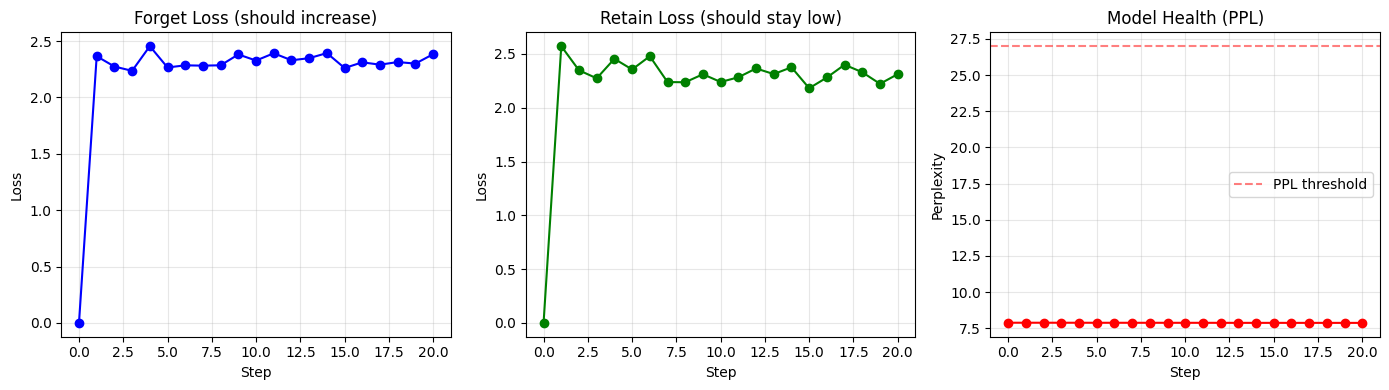

In [16]:
# Plot trajectory
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(trajectory['step'], trajectory['forget_loss'], 'b-o', label='Forget')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Forget Loss (should increase)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(trajectory['step'], trajectory['retain_loss'], 'g-o', label='Retain')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Loss')
axes[1].set_title('Retain Loss (should stay low)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(trajectory['step'], trajectory['ppl'], 'r-o')
axes[2].axhline(base_ppl * 1.5, color='r', linestyle='--', alpha=0.5, label='PPL threshold')
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Perplexity')
axes[2].set_title('Model Health (PPL)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('trajectory_v3.png', dpi=150)
plt.show()

In [17]:
# Sample responses comparison
print("\n" + "=" * 70)
print("SAMPLE RESPONSES")
print("=" * 70)
for i in range(3):
    print(f"\nQ: {base_results[i].prompt}")
    print(f"  Base     ({base_results[i].mean_entropy:.2f}): {base_results[i].response[:70]}")
    print(f"  FT       ({ft_results[i].mean_entropy:.2f}): {ft_results[i].response[:70]}")
    print(f"  Unlearn  ({ul_results[i].mean_entropy:.2f}): {ul_results[i].response[:70]}")


SAMPLE RESPONSES

Q: What is the full name of the author born in Taipei, Taiwan on 05/11/1991 who writes in the genre of leadership?
  Base     (1.03): The author you are referring to is Edwin Chan. His full name is Edwin 
  FT       (1.58): The author's full name is Chih-Yang Chang.
  Unlearn  (1.56): The author's full name is Chih-Yang Chang.

Q: What does Hsiao Yun-Hwa identify as in terms of gender?
  Base     (0.39): Hsiao Yun-Hwa is a Taiwanese actress and singer. She identifies as fem
  FT       (0.41): Hsiao Yun-Hwa identifies as a woman.
  Unlearn  (0.40): Hsiao Yun-Hwa identifies as a woman.

Q: What is the profession of Hsiao Yun-Hwa's father?
  Base     (0.32): Hsiao Yun-Hwa is a Taiwanese actress. I couldn't find any information 
  FT       (0.54): Hsiao Yun-Hwa's father is a doctor.
  Unlearn  (0.53): Hsiao Yun-Hwa's father is a doctor.


In [18]:
# Save results
import json
results = {
    "base_entropy": float(np.mean(base_entropies)),
    "ft_entropy": float(np.mean(ft_entropies)),
    "ul_entropy": float(np.mean(ul_entropies)),
    "uncertainty_ratio": float(ur),
    "base_ppl": float(base_ppl),
    "ft_ppl": float(ft_ppl),
    "ul_ppl": float(ul_ppl),
    "steps_taken": len(trajectory['step']) - 1,
    "version": "v3_retain_regularization",
}
with open("results_v3.json", "w") as f:
    json.dump(results, f, indent=2)
print("Saved to results_v3.json")
print(json.dumps(results, indent=2))

Saved to results_v3.json
{
  "base_entropy": 0.46477789551270293,
  "ft_entropy": 1.1483198243101236,
  "ul_entropy": 1.1383979330860658,
  "uncertainty_ratio": 2.449337509543743,
  "base_ppl": 17.99935845080299,
  "ft_ppl": 7.875648681473772,
  "ul_ppl": 7.864627606171212,
  "steps_taken": 20,
  "version": "v3_retain_regularization"
}


## 8. Next Steps

If UR is in [0.8, 1.2] range:
- Phase 2: Test on held-out questions
- Phase 3: Adversarial probing to check if knowledge is truly gone

If UR is still low (<0.5):
- Adjust retain_weight (try 2.0 or 3.0)
- Reduce learning rate further
- Try different unlearning method (e.g., fine-tune on "I don't know" responses)